####Import Statements

In [57]:
import re
import pandas as pd
from pyfasta import Fasta
import numpy as np
from collections import defaultdict
import itertools
import random

import primer3
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

plt.rc('font', family='serif') 
plt.rc('font', serif='Myriad Pro')
plt.rc('font', size=14)
sns.set(style="darkgrid")


#### Utilities

In [58]:
def prettify_ax(ax):
    for spine in ax.spines.itervalues():
        spine.set_visible(False)
    ax.set_frameon=True
    ax.patch.set_facecolor('#eeeeef')
    ax.grid('on', color='w', linestyle='-', linewidth=1)
    ax.tick_params(direction='out')
    ax.set_axisbelow(True)
    
def simple_ax(figsize=(6,4), **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, **kwargs)
    prettify_ax(ax)
    return fig, ax


compl = {'A':'T', 'T':'A', 'C':'G','G':'C'}
def revcompl(string):
    return ''.join(compl[s] for s in string[::-1])

def GCpct(s):
    return float(sum([(b=='G' or b=='C') for b in s]))/len(s)

bases = 'ATCG'
def random_seq(n):
    return ''.join(random.choice(bases) for _ in range(n))

Read primers, replace Us with Ts.

In [59]:
primers = pd.read_csv('primers.txt', sep=' ',names=['panel', 'gene', 'outer', 'inner'])
primers.outer = primers.outer.apply(lambda s: s.replace('U','T'))

#Ignore the first 22 nucleotides of inner primer (same from primer to primer).
primers.inner = primers.inner.apply(lambda s: s.replace('U','T')[22:])
primers.head()

,panel,gene,outer,inner
0,panel1,CD41,CCCCTGGAAGAAGATGATGA,TTCTCCAACAAGTTGCCTCC
1,panel1,GYPD,GAGGAAATGAAGCCAAACACA,AATCGTGACCTTAAAGGCCC
2,panel1,GATA1,TTAGCCACCTCATGCCTTTC,CTACTGTGGTGGCTCCGCT
3,panel1,GATA2,GGAGGAGGATTGTGCTGATG,GTGTCCGCATAAGAAAAAGAATC
4,panel1,HBG1,GCAAGAAGGTGCTGACTTCC,CTGCATGTGGATCCTGAGAA


Load hg19 transcripts

In [60]:
transcripts = Fasta('./hg19.transcripts.annotated.idx.fa')
tx_by_gene = defaultdict(list)
for tx in transcripts.keys():
    tx_by_gene[tx.split('|')[1]].append(tx)

In [61]:
primers['outer_gc'] = primers.outer.apply(GCpct)
primers['outer_tm'] = primers.outer.apply(primer3.calcTm)


primers['inner_gc'] = primers.inner.apply(GCpct)
primers['inner_tm'] = primers.inner.apply(primer3.calcTm)

primers['matched'] = False
primers['outer_to_tx_end'] = np.NaN
primers['inner_to_tx_end'] = np.NaN
primers['outer3_to_inner5'] = np.NaN
primers.head()

,panel,gene,outer,inner,outer_gc,outer_tm,inner_gc,inner_tm,matched,outer_to_tx_end,inner_to_tx_end,outer3_to_inner5
0,panel1,CD41,CCCCTGGAAGAAGATGATGA,TTCTCCAACAAGTTGCCTCC,0.500000,50.382505,0.500000,52.186337,False,NaN,NaN,NaN
1,panel1,GYPD,GAGGAAATGAAGCCAAACACA,AATCGTGACCTTAAAGGCCC,0.428571,51.186015,0.500000,52.048308,False,NaN,NaN,NaN
2,panel1,GATA1,TTAGCCACCTCATGCCTTTC,CTACTGTGGTGGCTCCGCT,0.500000,52.032747,0.631579,55.842198,False,NaN,NaN,NaN
3,panel1,GATA2,GGAGGAGGATTGTGCTGATG,GTGTCCGCATAAGAAAAAGAATC,0.550000,52.246970,0.391304,50.786669,False,NaN,NaN,NaN
4,panel1,HBG1,GCAAGAAGGTGCTGACTTCC,CTGCATGTGGATCCTGAGAA,0.550000,53.394404,0.500000,51.469684,False,NaN,NaN,NaN


In [62]:

polyA_tail_length = 125

genes_not_in_reference = []
primers_fail_to_match = []

for i, (gene, outer, inner) in primers[['gene', 'outer', 'inner']].iterrows():
    
    if gene in tx_by_gene:
        gene_dists = []
        
        matches = []
        
        for tx in tx_by_gene[gene]:
            inner_match = re.search(inner, str(transcripts[tx]))
            outer_match = re.search(outer, str(transcripts[tx]))
            
            if inner_match and outer_match:
                outer_to_tx_end = len(transcripts[tx]) - outer_match.start(0) - polyA_tail_length
                inner_to_tx_end = len(transcripts[tx]) - inner_match.start(0) - polyA_tail_length
                outer3_to_inner5 = inner_match.start(0) - outer_match.end(0)
                
                
                matches.append((tx, outer_to_tx_end, inner_to_tx_end, outer3_to_inner5))
                
        if matches:
            #Record only cases where all matches are the same distances...
            #Print the rest for manual inspection.
            zm = zip(*matches)
            if np.std(zm[1])>0 or np.std(zm[2])>0 or np.std(zm[3])>0:
                print matches
            else:
                primers['matched'][i] = True
                primers['outer_to_tx_end'][i] = matches[0][1]
                primers['inner_to_tx_end'][i] = matches[0][2]
                primers['outer3_to_inner5'][i] = matches[0][3]
            
        else:
            primers_fail_to_match.append((gene, tx, outer, inner))    
                
    else:
        genes_not_in_reference.append(gene)

[('NM_032962|CCL14', 456, 308, 128), ('NM_032963|CCL14', 408, 308, 80)]
[('NM_001185101|CD22', 320, 228, 72), ('NM_001278417|CD22', 316, 224, 72), ('NM_001185099|CD22', 320, 228, 72), ('NM_001185100|CD22', 320, 228, 72), ('NM_001771|CD22', 320, 228, 72)]
[('NM_021803|IL21', 496, 416, 60), ('NM_001207006|IL21', 586, 506, 60)]
[('NM_021803|IL21', 486, 391, 75), ('NM_001207006|IL21', 576, 481, 75)]
[('NM_032962|CCL14', 445, 342, 83), ('NM_032963|CCL14', 397, 342, 35)]


In [63]:
set(primers.panel)

{'panel1', 'panel2', 'panel3', 'panel4'}

#### Distributions of primer parameters.

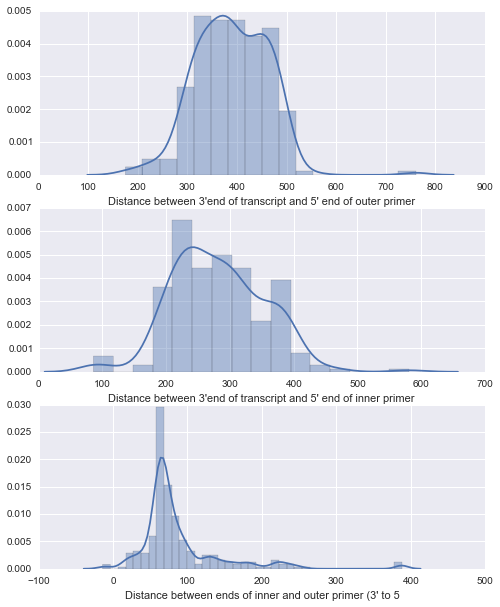

In [64]:
f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8, 10))

primer_filter = primers.matched==True

g = sns.distplot(primers[primer_filter]['outer_to_tx_end'], ax=ax1, axlabel="Distance between 3'end of transcript and 5' end of outer primer") 
g = sns.distplot(primers[primer_filter]['inner_to_tx_end'], ax=ax2, axlabel="Distance between 3'end of transcript and 5' end of inner primer") 
g = sns.distplot(primers[primer_filter]['outer3_to_inner5'], ax=ax3, axlabel="Distance between ends of inner and outer primer (3' to 5") 

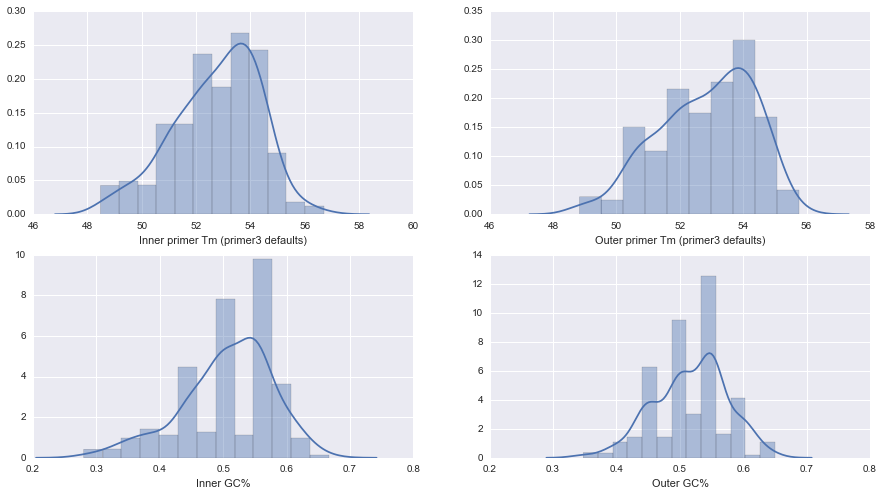

In [66]:
f, ((ax1, ax2,), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))

g = sns.distplot(primers[primer_filter]['inner_tm'], ax=ax1, axlabel="Inner primer Tm (primer3 defaults)") 
g = sns.distplot(primers[primer_filter]['outer_tm'], ax=ax2, axlabel="Outer primer Tm (primer3 defaults)") 
g = sns.distplot(primers[primer_filter]['inner_gc'], ax=ax3, axlabel="Inner GC%") 
g = sns.distplot(primers[primer_filter]['outer_gc'], ax=ax4, axlabel="Outer GC%")

#### Thermodynamic parameters of primer with targets sequence vs. primer pairs in panel.

In [55]:
p1 = primers.panel=='panel1'
for s1, s2 in itertools.combinations(primers[p1].outer, 2):
    x = primer3.bindings.calcEndStability(s1, s2)

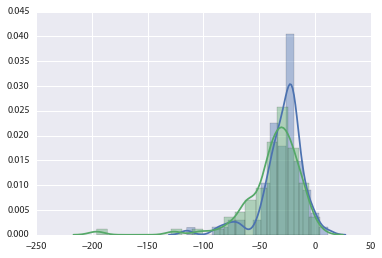

In [35]:

dd1 = [primer3.bindings.calcEndStability('CACATGGCCTCCAAGGAGTAA', s2).tm for s2 in primers[primers.panel=='panel4'].outer]
dd2 = [primer3.bindings.calcEndStability('GACTTCAACAGCGACACCCA', s2).tm for s2 in primers[primers.panel=='panel4'].outer]

fig, ax = plt.subplots(1)
sns.distplot(dd1, ax=ax)
sns.distplot(dd2, ax=ax)

In [6]:
primers.ix[0, 'gene']

'CD41'

In [36]:
pairwise_end_tm = defaultdict(dict)
indices = primers[primers.panel=='panel2'].index
for i, j in itertools.combinations(indices, 2):
    tm = primer3.bindings.calcHeterodimer(primers.ix[i, 'outer'], primers.ix[j, 'outer'])
    pairwise_end_tm[i][j] = tm
    pairwise_end_tm[j][i] = tm
    
for i in indices:
    pairwise_end_tm[i][i] = primer3.bindings.calcHeterodimer(primers.ix[i, 'outer'], primers.ix[i, 'outer'])

    
    
    

In [37]:
thermo = pd.DataFrame(pairwise_end_tm, index=indices, columns=indices)

tms = thermo.apply(lambda col: col.apply(lambda th: th.tm))
dgs = thermo.apply(lambda col: col.apply(lambda th: th.dg))



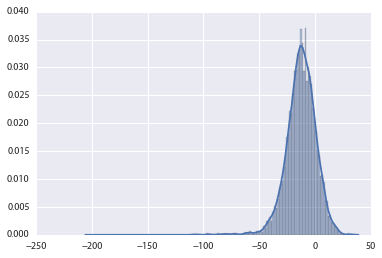

In [24]:
fig, ax = plt.subplots(1)
sns.distplot(tms.as_matrix().flat, ax=ax)

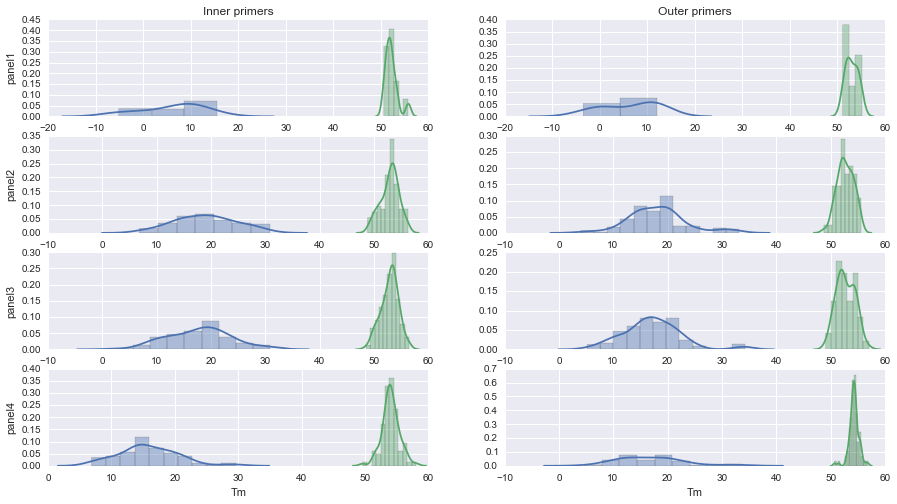

In [70]:
def pairwise_thermodynamics(primers):
    primer_dimers = defaultdict(dict)
    on_target = {}
    for p1, p2 in itertools.combinations(primers, 2):
        thermo = primer3.bindings.calcHeterodimer(p1, p2)
        primer_dimers[p1][p2] = thermo
        primer_dimers[p2][p1] = thermo
        
    for p1 in primers:
        primer_dimers[p1][p1] = primer3.bindings.calcHeterodimer(p1, p1)
        on_target[p1] = primer3.bindings.calcHeterodimer(p1, revcompl(p1))
    
    return primer_dimers, on_target

f, axes = plt.subplots(4, 2, figsize=(15, 8))


for p, panel in enumerate(['panel1', 'panel2', 'panel3', 'panel4']):
    
    filt = primers.panel == panel
    
    for i, primer_set in enumerate(['inner', 'outer']):
    
        primer_seqs = primers[filt][primer_set]
    
        dimers, targets = pairwise_thermodynamics(primer_seqs)

        dimers = pd.DataFrame(dimers)
        targets = pd.Series(targets)
        dimers_tms = dimers.apply(lambda col: col.apply(lambda th: th.tm))
#         dimers_dgs = dimers.apply(lambda col: col.apply(lambda th: th.dg))

        targets_tms = targets.apply(lambda th: th.tm)
#         targets_dgs = targets.apply(lambda th: th.dg)
    
        sns.distplot(dimers_tms.max(), ax=axes[p][i])
        sns.distplot(targets_tms, ax=axes[p][i])
                
                          
    axes[p][0].set_ylabel(panel)
    
    
axes[0][0].set_title('Inner primers')
axes[0][1].set_title('Outer primers')
axes[3][0].set_xlabel('Tm')
axes[3][1].set_xlabel('Tm')


In [ ]:
# Could eventually use this to recover more genes for analysis
# translation_table = {
# 'CD30': 'TNFRSF8' ,
#  'IGHG1': ,
#  'IGHG2',
#  'IGHG3',a
#  'OX40L': 'TNFSF4',
#  'GYPD',
#  'IGHG4',
#  'CD21': 'CR2',
#  'CD20': 'MS4A1',
#  'CD25': 'IL2RA,
#  'CMRF-35H',
#  'CD1d': 'CD1D',
#  'CD1e': 'CD1E',
#  'CD1b': 'CD1B',
#  'CD1c': 'CD1C',
#  'KIR2DS5',
#  'KIR2DS2',
#  'CD41',
#  'IGHA',
#  'CD95',
#  'CD16',
#  'CD10',
#  'CD73',
#  'BAFFR',
#  'CD138',
#  'TNFA',
#  'BAFF',
#  'CD79a',
#  'CRTH2',
#  'CD30L',
#  'CD23a',
#  'CD56',
#  'CCR2variantB',
#  'CCR2variantA',
#  'CD62L',
#  'THPOK',
#  'TACI',
#  'IGHD',
#  'IGHE',
#  'PTPRCvariant1',
#  'PTPRCvariant5',
#  'IGHM',
#  'IL33R',
#  'CD11b',
#  'CD11c'
# }